# Estimate exposure time

In [1]:
import os
if not os.path.isfile("ECL-RSP-ARF_20211023T01.fits"):
    os.system("wget https://github.com/fcangemi/gp-tools-svom/raw/main/ECL-RSP-ARF_20211023T01.fits")
if not os.path.isfile("MXT_FM_PANTER_FULL-ALL-1.0.arf"):
    os.system("wget https://github.com/fcangemi/gp-tools-svom/raw/main/MXT_FM_PANTER_FULL-ALL-1.0.arf")
!pip install astropy
!pip install lmfit

In [2]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from lmfit.models import ExpressionModel
from lmfit import minimize, Minimizer, Parameters, Parameter, report_fit

In [3]:
def read_arf(arf_filename):
    hdu1 = fits.open(arf_filename)
    arf_data=hdu1[1].data
    
    emin = arf_data.ENERG_LO
    emax = arf_data.ENERG_HI
    arf = arf_data.SPECRESP

    dE = emax - emin
    E = emin + (emax - emin) / 2

    return E, emin, emax, dE, arf

def bbody(x, phi0, kT):
    return phi0 * 8.0525 * x**2 / (kT**4 * (np.exp(x/kT) - 1))

def powerlaw(x, norm, Gamma):
    return norm * x**(-Gamma)

def cutoffpl(x, norm, Gamma, E_cut):
    return norm * x**(-Gamma) * np.exp(-x / E_cut)

#def powerlaw(params, x, data, error):
#    norm = params['norm']
#    Gamma = params['Gamma']
#    model = norm * x**(-Gamma)
#    return (model - data) / error

def function(x, a):
    return np.exp(- a * 1.5 / x ** 3)

def absorption():
    # From Strom & Strom 1961
    data = np.genfromtxt("absorption.txt", unpack = True, delimiter = ",",
                        skip_header = 1)
    wavelength = data[0]
    tau = data[1]
    norm_I = data[2]
    E = c.h * c.speed_of_light / (wavelength * 1e-10) * 6.242e15 # energy in keV
    plt.plot(E, norm_I, label = "data")
    plt.yscale("log")
    
    # Fit
    params, covs = curve_fit(function, E, norm_I, p0 = [0.50])
    print("params: ", params)
    
    plt.plot(E, function(E, params[0]), label = "Best fit")
    plt.ylim([1e-4, 1e1])
    plt.legend()
    plt.xlim([0, 2])

def plot_F(ax, E, F):
    ax.plot(E, F, color = "black", linewidth = 3)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Energy [keV]")
    ax.set_ylabel("F(E) [ph/cm2/s/keV]")

def plot_EF(ax, E, EF):
    ax.plot(E, EF, color = "black", linewidth = 3)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Energy [keV]")
    ax.set_ylabel("EF(E) [ph/cm2/s]")

def calculate_norm_from_flux(flux, Gamma, Emin, Emax):
    return flux * (-Gamma + 2) / (Emax**(-Gamma + 2) - Emin**(-Gamma + 2)) * 6.242e8

def calculate_flux_from_norm(norm, Gamma, Emin, Emax): 
    return norm / (-Gamma + 2) * (Emax**(-Gamma + 2) - Emin**(-Gamma + 2)) / 6.242e8

def calculate_countrate(n_H, Eband, instrument, model, plot = 1):
    if(instrument == "MXT"):
        E, emin, emax, dE, arf = read_arf("MXT_FM_PANTER_FULL-ALL-1.0.arf")
    else:
        E, emin, emax, dE, arf = read_arf("ECL-RSP-ARF_20211023T01.fits")

    if((Eband[0] <= E[0] - dE[0]) or (Eband[-1] >= E[-1] + dE[-1])):
        print("ERROR: energy band outside the arf energy range !")
    else:
        E_r = E[(E>=Eband[0]) & (E<=Eband[1])]
        dE_r = dE[(E>=Eband[0]) & (E<=Eband[1])]
        arf_r = arf[(E>=Eband[0]) & (E<=Eband[1])]
        emax_r = emax[(E>=Eband[0]) & (E<=Eband[1])]
        emin_r = emin[(E>=Eband[0]) & (E<=Eband[1])]
        
        a = 0.286733
        
        if(model == "powerlaw"):
            F = norm * E_r**(-Gamma) * np.exp(- n_H * a / E_r**3)
            #print("Absorbed flux = ", sum(norm * E_r**(-Gamma) * np.exp(- n_H * a / E_r**3) * dE_r) / 6.242e8, "erg/s/cm2")
            countrate = sum(arf_r * norm * E_r**(-Gamma) * np.exp(- n_H * a / E_r**3) * dE_r)
            
        elif(model == "cutoffpl"):
            F = norm * E_r**(-Gamma) * np.exp(-E_r / E_cut) * np.exp(- n_H * a / E_r**3)
            countrate = sum(arf_r * norm * E_r**(-Gamma) * np.exp(-E_r / E_cut) * np.exp(- n_H * a / E_r**3) * dE_r)
        
        elif(model == "bbody"):
            F = norm * 8.0525 * E_r**2 / (kT**4 * (np.exp(E_r/kT) - 1)) * np.exp(- n_H * a / E_r**3)
            countrate = sum(arf_r * norm * 8.0525 * E_r**2 / (kT**4 * (np.exp(E_r/kT) - 1)) * np.exp(- n_H * a / E_r**3) * dE_r)
            
        else: # Brokenpowerlaw
            F = np.ones(len(E_r))
            countrate = 0
            for i in range(len(E_r)):
                if(E_r[i] <= E_break):
                    F[i] = norm * E_r[i]**(-alpha) * np.exp(- n_H * a / E_r[i]**3)
                    countrate += arf_r[i] * norm * E_r[i]**(-alpha) * np.exp(- n_H * a / E_r[i]**3) * dE_r[i]
                    
                else:
                    F[i] = norm * E_r[i]**(-beta) * E_break**(beta - alpha) * np.exp(- n_H * a / E_r[i]**3)
                    countrate += arf_r[i] * norm * E_r[i]**(-beta) * E_break**(beta - alpha) * dE_r[i] * np.exp(- n_H * a / E_r[i]**3)
        if (plot == 1):
            fig = plt.figure(figsize = (7, 5))
            plt.plot(E_r, F, label = "Source", color = "red", linewidth = 3)
            plt.xscale("log")
            plt.yscale("log")
            plt.xlabel("Energy [keV]")
            plt.ylabel("ph/cm2/s/keV")
            #plt.ylim([0.01, 2])
        flux_simu = countrate / sum(arf_r * dE_r)
        return countrate, flux_simu

def calculate_background(instrument, Eband, plot = 1):
    a = 0.286733
    if(instrument == "ECLAIRs"):
        E, emin, emax, dE, arf = read_arf("ECL-RSP-ARF_20211023T01.fits")
    else:
        E, emin, emax, dE, arf = read_arf("MXT_FM_PANTER_FULL-ALL-1.0.arf")
        
    if((Eband[0] <= E[0] - dE[0]) or (Eband[-1] >= E[-1] + dE[-1])):
        print("ERROR: energy band outside the arf energy range !")
    else:
        E_r = E[(E>=Eband[0]) & (E<=Eband[1])]
        dE_r = dE[(E>=Eband[0]) & (E<=Eband[1])]
        arf_r = arf[(E>=Eband[0]) & (E<=Eband[1])]
        emax_r = emax[(E>=Eband[0]) & (E<=Eband[1])]
        emin_r = emin[(E>=Eband[0]) & (E<=Eband[1])]
        
        if(instrument == "ECLAIRs"):
            # 2SJPL Model from Moretti+2009
            Gamma_1 = 1.4
            Gamma_2 = 2.88
            E_B = 29             # keV
            norm = 0.109         # ph/cm2/s/keV/sr
            F = norm / ((E_r / E_B)**(Gamma_1) + (E_r / E_B)**(Gamma_2))
            countrate = sum(arf_r / (0.24 * 1024) * 0.16 * 0.3436 * 80 * 80 * norm / ((E_r / E_B)**(Gamma_1) + (E_r / E_B)**(Gamma_2)) * dE_r)
            
        else:
            # Powerlaw Model from Moretti+2009
            norm = 3.67e-3 * 65318 * (13.5*0.0002777)**2 #norm in ph/cm2/s/keV/deg2 * nb pixel contributing to the PSF * (13.5 arcsec/pixel)**2
            Gamma = 1.47
            F = norm * E_r**(-Gamma)
            #countrate = sum(arf_r * norm * E_r**(-Gamma) * dE_r)
            F = norm * E_r**(-Gamma) * np.exp(- n_H * a / E_r**3)
            countrate = sum(arf_r * norm * E_r**(-Gamma) * np.exp(- n_H * a / E_r**3) * dE_r)
        
        if(plot == 1):
            plt.plot(E_r, F, color = "blue", label = "CXB")
            plt.legend()
            plt.show()
    return countrate

def calculate_exposure(SNR, instrument, Eband):
    print("Emin  = ", Eband[0], "keV")
    print("Emax  = ", Eband[1], "keV")
    print("norm  = ", f'{norm:.4f}', "ph/s/cm2/keV")
    
    if(model == "powerlaw"):
        print("Gamma = ", Gamma)
    elif(model == "bknpowerlaw"):
        print("alpha = ", alpha)
        print("beta  = ", beta)
        print("E_break = ", E_break, "keV")
    elif(model == "bbody"):
        print("kT    = ", kT, "keV")
    else:
        print("Gamma = ", Gamma)
        print("E_cut = ", E_cut)
    print("n_H   = ", n_H, "e21 cm-2")
    
    source, flux_simu = calculate_countrate(n_H, Eband, instrument, model)
    if(instrument == "MXT"):
        
        background = calculate_background("MXT", Eband)
        exposure = (SNR  / source * np.sqrt(source + background))**2
    else:
        background = calculate_background("ECLAIRs", Eband)
        exposure = (SNR  / source * np.sqrt(source / 0.4 + background))**2 # Skinner+2008
    
    print("Background =", f'{background:.4f}', "c/s in the energy band", Eband, "keV.")
    print("Source =", f'{source:.4f}', "c/s in the energy band", Eband, "keV.")
    print(instrument, ": need an exposure time of", f'{exposure:.2f}', "seconds for a SNR =", SNR, "over the energy band", Eband, "keV.")

    
def make_spectra(instrument, nbins, tps_expo, title = " ", path_to_fig = " ", ylim1 = " ", ylim2 = " ", color = "black"):
    if(instrument == "ECLAIRs"):
        E = np.logspace(0.4, 2.15, nbins + 1)
    else:
        E = np.logspace(-1, 1, nbins + 1)
    
    print("norm  = ", f'{norm:.4f}', "ph/s/cm2/keV")
    
    if(model == "powerlaw"):
        print("Gamma = ", Gamma)
    elif(model == "bknpowerlaw"):
        print("alpha = ", alpha)
        print("beta  = ", beta)
        print("E_break = ", E_break, "keV")
    elif(model == "bbody"):
        print("kT    = ", kT, "keV")
    else:
        print("Gamma = ", Gamma)
        print("E_cut = ", E_cut)
    print("n_H   = ", n_H, "e21 cm-2")
    
    Emin = E[0:-1]
    Emax = E[1:]
    Ebin = Emax - Emin
    SNR = []
    countrate = []
    energy = Emin + (Emax - Emin) / 2
    flux_simu = []
    background = []
    error = []

    for emin, emax in zip(Emin, Emax):

        src, f_simu = calculate_countrate(n_H, [emin, emax], instrument, model, plot = 0)
        bkg = calculate_background(instrument, [emin, emax], plot = 0)
        err = np.sqrt(src * tps_expo) 
        if(instrument == "ECLAIRs"):
            snr = src / np.sqrt(src / 0.4 + bkg) * np.sqrt(tps_expo) # for ECLAIRs
        else:
            snr = src / np.sqrt(src + bkg) * np.sqrt(tps_expo) # for MXT
        SNR.append(snr)
        countrate.append(src)
        flux_simu.append(f_simu)
        background.append(bkg)
        error.append(err)
    
    # PLOTS
    fig, ax = plt.subplots(figsize = (11, 5), nrows = 1, ncols = 2) 
    fig.suptitle(instrument + "," + title + ", $t_{expo} =$" + str(tps_expo) + " s, \n" + model)
    yerr = np.asarray(error) / tps_expo
    #ax[0].errorbar(energy, countrate, xerr = Ebin / 2, yerr = yerr, color = "black")
    #ax[0].set_xscale("log")
    #ax[0].set_yscale("log")
    #ax[0].set_xlabel("Energy [keV]")
    #ax[0].set_ylabel("counts/s/keV")
    #if(ylim1 != " "):
    #    ax[0].set_ylim(ylim1)
    ax[0].plot(energy, SNR, 'o-', color = color)
    ax[0].set_xscale("log")
    #ax[0].set_yscale("log")
    ax[0].set_xlabel("Energy [keV]")
    ax[0].set_ylabel("SNR")
    
    a = 0.286733
    #flux_simu_err = yerr / countrate * flux_simu
    flux_simu_err = flux_simu / np.asarray(SNR)
    ax[1].errorbar(energy, flux_simu, # * np.exp(- n_H * a / energy**3), 
                   xerr = Ebin / 2, yerr = flux_simu_err, fmt = ".",
                   label = "simulated spectrum", color = "black")
    
    idx = np.where(np.isnan(flux_simu_err) == False)[0]
    energy_g = energy[idx]
    flux_simu_g = np.asarray(flux_simu)[idx]
    flux_simu_err_g = flux_simu_err[idx]
    if(model == "powerlaw"):
        gmod = ExpressionModel("norm * x**(-Gamma) * exp(- n_H * 0.286733 / x**3)")
        params = gmod.make_params(norm = 1, Gamma = 2, n_H = 20.)
        params["n_H"].set(min = 0.1)
        params["n_H"].set(max = 120.) 
        result = gmod.fit(flux_simu_g, params, x = energy_g, weights = 1. / flux_simu_err_g, scale_covar=False)
        ax[1].plot(energy, powerlaw(energy, result.params["norm"], result.params["Gamma"]) * np.exp(- result.params["n_H"] * 0.286733 / energy**3),
                  color = "red", linewidth = 3, label = "Best fit")
        
    elif(model == "cutoffpl"):
        gmod = ExpressionModel("norm * x**(-Gamma) * exp(-x / E_cut) * exp(- n_H * 0.286733 / x**3)")
        params = gmod.make_params(norm = 1., Gamma = 1.7, E_cut = 70., n_H = 20.)
        params["E_cut"].set(min = 1.)
        params["E_cut"].set(max = 500.)
        params["n_H"].set(min = 0.1)
        params["n_H"].set(max = 120.) 
        result = gmod.fit(flux_simu_g, params, x = energy_g, weights = 1. / flux_simu_err_g, scale_covar=False, max_nfev = 10000)
        ax[1].plot(energy, cutoffpl(energy, result.params["norm"], result.params["Gamma"], result.params["E_cut"]) * np.exp(- result.params["n_H"] * 0.286733 / energy**3),
                  color = "red", linewidth = 3, label = "Best fit")
    
    elif(model == "bbody"):
        gmod = ExpressionModel("norm * 8.0525 * x**2 / (kT**4 * (exp(x/kT) - 1)) * exp(- n_H * 0.286733 / x**3)")
        params = gmod.make_params(norm = 1., kT = 1, n_H = 20.)
        params["norm"].set(min = 0.001)
        params["norm"].set(max = 10)
        params["kT"].set(min = 0.01)
        params["kT"].set(max = 3.)
        params["n_H"].set(min = 0.1)
        params["n_H"].set(max = 120.) 
        result = gmod.fit(flux_simu_g, params, x = energy_g, weights = 1. / flux_simu_err_g, scale_covar=False, max_nfev = 10000)
        ax[1].plot(energy, bbody(energy, result.params["norm"], result.params["kT"]) * np.exp(- result.params["n_H"] * 0.286733 / energy**3),
                  color = "red", linewidth = 3, label = "Best fit")
    print(result.fit_report())
     
    ax[1].set_xscale("log")
    ax[1].set_yscale("log")
    ax[1].set_ylabel("ph/s/cm2/keV")
    ax[1].set_xlabel("Energy [keV]")
    ax[1].legend()
    #plt.title(instrument + "," + title + ", $t_{expo} =$" + str(tps_expo) + " s")
    if(ylim2 != " "):
        ax[1].set_ylim(ylim2)
    
    if(model == "powerlaw"):
        ax[1].set_title("norm   = " + str(result.params["norm"].value)[0:5] + " +/- " + 
                        str(result.params["norm"].stderr)[0:5] + "\n"
                        "Gamma = " + str(result.params["Gamma"].value)[0:5] + " +/- " + 
                        str(result.params["Gamma"].stderr)[0:5] +  "\n"
                        "n_H    = " + str(result.params["n_H"].value)[0:5] + " +/- " + 
                        str(result.params["n_H"].stderr)[0:5] + "$\\times 10^{21}$ cm-2",
                        fontsize = 8)
        
    elif(model == "cutoffpl"):
        ax[1].set_title("norm   = " + str(result.params["norm"].value)[0:5] + " +/- " + 
                        str(result.params["norm"].stderr)[0:5] + "\n"
                        "Gamma = " + str(result.params["Gamma"].value)[0:5] + " +/- " + 
                        str(result.params["Gamma"].stderr)[0:5] +  "\n"
                        "E_cut = " + str(result.params["E_cut"].value)[0:5] + " +/- " + 
                        str(result.params["E_cut"].stderr)[0:5] +  " keV \n"
                        "n_H    = " + str(result.params["n_H"].value)[0:5] + " +/- " + 
                        str(result.params["n_H"].stderr)[0:5] + "$\\times 10^{21}$ cm-2",
                        fontsize = 8)
        
    elif(model == "bbody"):
        ax[1].set_title("norm   = " + str(result.params["norm"].value)[0:5] + " +/- " + 
                        str(result.params["norm"].stderr)[0:5] + "\n"
                        "kT = " + str(result.params["kT"].value)[0:5] + " +/- " + 
                        str(result.params["kT"].stderr)[0:5] +  " keV\n"
                        "n_H    = " + str(result.params["n_H"].value)[0:5] + " +/- " + 
                        str(result.params["n_H"].stderr)[0:5] + "$\\times 10^{21}$ cm-2",
                        fontsize = 8)
    
    
    if(path_to_fig != " "):
        fig.savefig(path_to_fig + title + "_" + instrument + "_" + str(tps_expo) + "s_" + str(nbins) + "bins.pdf", bbox_inches = "tight")

This notebook uses ancillary response files of MXT and ECLAIRs in order to calculate the exposure time needed to achieve a signal to noise ratio given the spectrum of a source.
#### 1. Choose the model and define parameters
**Four types** of models can be used: 

##### Simple powerlaw, "**powerlaw**":
$$
N(E) = \phi_0 E^{-\Gamma}
$$
- $\phi_0$: flux normalization at 1 keV in **ph/cm2/s/keV**, named "**norm**" in this notebook;
- $\Gamma$: photon index, named "**Gamma**" in this notebook.

**NB**: for this model, you can alternatively calculate the flux normalization $\phi_0$ by calling **calculate_norm_from_flux(unabsorbed_flux, Gamma, Emin, Emax)** and giving the ***unabsorbed flux*** in **ergs/cm2/s** between **Emin keV** and **Emax keV**.

##### Broken powerlaw, "**bknpowerlaw**":
$$
N(E) = \left\{
    \begin{array}{ll}
        \phi_0 E^{-\alpha} & \mbox{if } E \leq E_\mathrm{break} \\
        \phi_0 E_\mathrm{break}^{\beta-\alpha} E^{-\beta} & \mbox{if } E > E_\mathrm{break}
    \end{array}
\right.
$$
- $\phi_0$: flux normalization at 1 keV in **ph/cm2/s/keV**, named "**norm**" in this notebook;
- $E_\mathrm{break}$: break energy in **keV**, named "**E_break**" in this notebook;
- $\alpha$: photon index of the low energy powerlaw, named "**alpha**" in this notebook;
- $\beta$: photon index of the high energy powerlaw, named "**beta**" in this notebook.

##### Cutoff powerlaw, "**cutoffpl**":
$$
N(E) = \phi_0 E^{-\Gamma} e^\frac{E}{E_\mathrm{cut}} 
$$
- $\phi_0$: flux normalization at 1 keV in **ph/cm2/s/keV**, named "**norm**" in this notebook;
- $\Gamma$: photon index, named "**Gamma**" in this notebook;
- $E_\mathrm{cut}$: cutoff energy in **keV**, "**E_cut**" in this notebook.

##### Black body, "**bbody**":
$$
N(E) = \frac{\phi_0 \times 8.0525 E^2}{(kT^4)[e^{\frac{E}{kT}} - 1]}
$$

- $\phi_0$: flux normalization: $\phi_0 = L_{39}/D_{10}^2$, where $L_{39}$ is the source luminosity in unit of $10^{39}$ erg/s and $D_{10}$ is the distance to the source in units of 10 kpc. (See https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/node137.html);
- $kT$: temperature in **keV**, name "**kT**" in this notebook;

For all the models, absorption is taken into account thanks to the hydrogen density column parameter **n_H**, in **$10^{21}$cm$^{-2}$**.

#### 2. Calculate the exposure
Once you have defined your model and the corresponding parameters, you can call "**calculate_exposure(SNR, instrument, Eband)**" to calculate the exposure time needed. This function has three arguments:
- "**SNR**": Signal to Noise Ratio;
- "**instrument**": you can choose between "MXT" or "ECLAIRs";
- "**Eband**": energy band for which you want to calculate the exposure time, [**Emin**, **Emax**], **Emin** and **Emax** in **keV**.


To edit the cells, `click on the rocket` at the top of this page, and then `click on the "Live Code"` button. Once your cell is edited you can `click on "run"` (the first time you are running, you may need to click on `"restart & run all"`).

### Few examples
#### Powerlaw (example for the Crab)

Emin  =  4 keV
Emax  =  150 keV
norm  =  10.0000 ph/s/cm2/keV
Gamma =  2.1
n_H   =  4.5 e21 cm-2


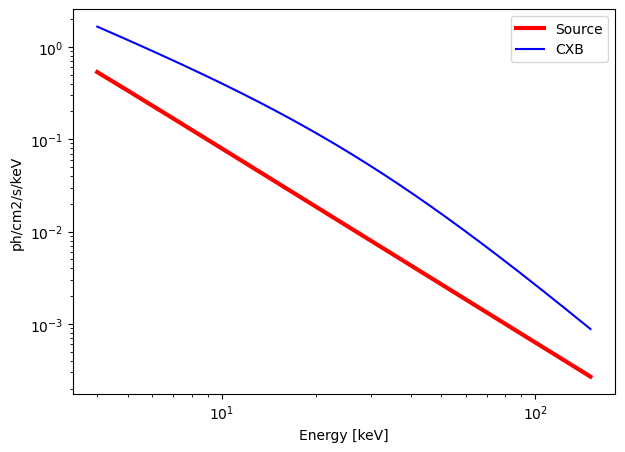

Background = 3587.2578 c/s in the energy band [4, 150] keV.
Source = 523.9236 c/s in the energy band [4, 150] keV.
ECLAIRs : need an exposure time of 1.78 seconds for a SNR = 10 over the energy band [4, 150] keV.


In [4]:
# Model and parameters
model = "powerlaw"
norm  = 10         # Flux normalisation in ph/cm2/s/keV
Gamma = 2.1        # Photon index
n_H   = 4.5        # Density column in 1e21 cm-2

# Exposure time
calculate_exposure(SNR = 10, instrument = "ECLAIRs", Eband = [4, 150])

Alternatively, you can give the unabsorbed flux to calculate the flux normalization:

Emin  =  0.2 keV
Emax  =  10 keV
norm  =  10.0805 ph/s/cm2/keV
Gamma =  2.1
n_H   =  4.5 e21 cm-2


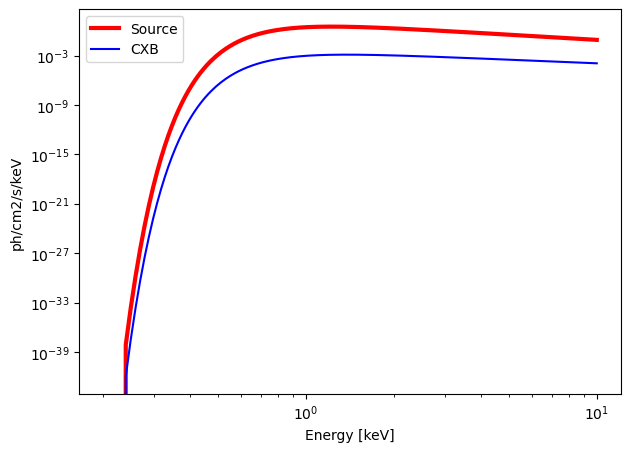

Background = 0.0594 c/s in the energy band [0.2, 10] keV.
Source = 131.8547 c/s in the energy band [0.2, 10] keV.
MXT : need an exposure time of 0.19 seconds for a SNR = 5 over the energy band [0.2, 10] keV.


In [5]:
unabsorbed_flux = 2.24e-8   # Unabsorbed flux in ergs/cm2/s between 2-10 keV
norm = calculate_norm_from_flux(unabsorbed_flux, Gamma, 2, 10)
calculate_exposure(SNR = 5, instrument = "MXT", Eband = [0.2, 10])

#### Broken Powerlaw

Emin  =  4 keV
Emax  =  150 keV
norm  =  0.1000 ph/s/cm2/keV
alpha =  1.3
beta  =  2.6
E_break =  30 keV
n_H   =  2.0 e21 cm-2


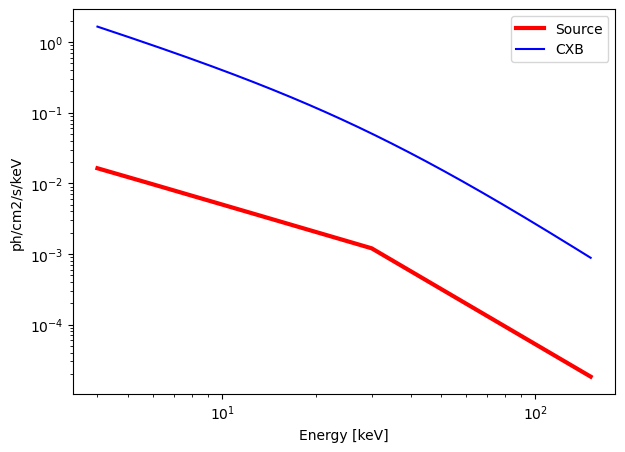

Background = 3587.2578 c/s in the energy band [4, 150] keV.
Source = 35.7848 c/s in the energy band [4, 150] keV.
ECLAIRs : need an exposure time of 2584.09 seconds for a SNR = 30 over the energy band [4, 150] keV.


In [6]:
model   = "bknpowerlaw"
norm    = 0.1           # Flux normalisation in ph/cm2/s/keV
E_break = 30            # Break energy in keV
alpha   = 1.3           # Photon index of the low energy powerlaw
beta    = 2.6           # Photon index of the high energy powerlaw
n_H     = 2.0           # Density column in 1e21 cm-2
calculate_exposure(SNR = 30, instrument = "ECLAIRs", Eband = [4, 150])

#### Cutoff Powerlaw

Emin  =  4 keV
Emax  =  100 keV
norm  =  0.1000 ph/s/cm2/keV
Gamma =  1.7
E_cut =  40
n_H   =  0 e21 cm-2


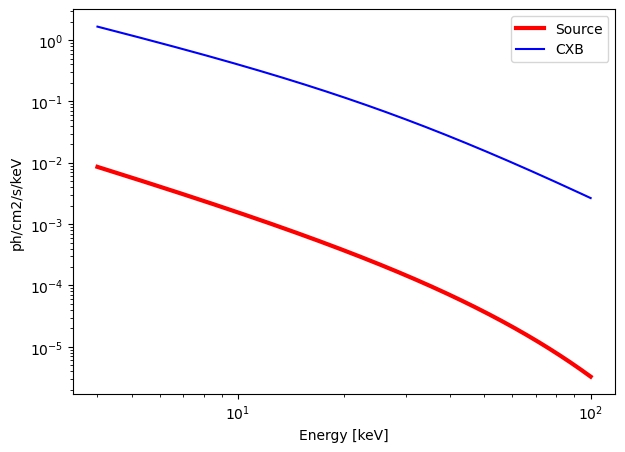

Background = 3569.5199 c/s in the energy band [4, 100] keV.
Source = 9.4439 c/s in the energy band [4, 100] keV.
ECLAIRs : need an exposure time of 4028.72 seconds for a SNR = 10 over the energy band [4, 100] keV.


In [7]:
model = "cutoffpl"
norm  = 0.1         # Flux normalisation in ph/cm2/s/keV
E_cut = 40          # Energy cutoff in keV
Gamma = 1.7         # Photon index
n_H   = 0           # Density column in 1e21 cm-2
calculate_exposure(SNR = 10, instrument = "ECLAIRs", Eband = [4, 100])

#### Black Body

Emin  =  0.2 keV
Emax  =  10 keV
norm  =  1.0000 ph/s/cm2/keV
kT    =  0.5 keV
n_H   =  0.0 e21 cm-2


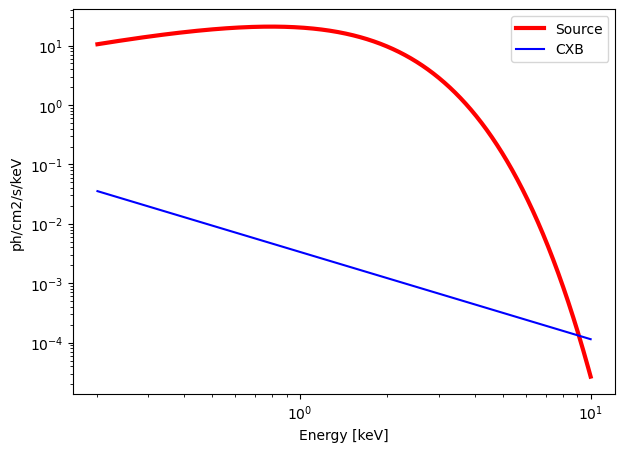

Background = 0.2285 c/s in the energy band [0.2, 10] keV.
Source = 957.6226 c/s in the energy band [0.2, 10] keV.
MXT : need an exposure time of 0.05 seconds for a SNR = 7 over the energy band [0.2, 10] keV.


In [8]:
model = "bbody"
norm  = 1.       # normalization
kT    = 0.5      # Black body temperature in keV
n_H   = 0.       # Density column in 1e21 cm-2

calculate_exposure(SNR = 7, instrument = "MXT", Eband = [0.2, 10])

# Simulate your spectra

First define your model parameters (works for powerlaw, cutoffpl, bbody):

In [9]:
model = "cutoffpl"
norm  = 10           # Flux normalisation in ph/cm2/s/keV
E_cut = 40          # Energy cutoff in keV
Gamma = 2.1         # Photon index
n_H   = 2           # Density column in 1e21 cm-2

Then define the parameters to compute the spectrum :
- **instrument**: the instrument "MXT" or "ELCAIRs"
- **nbins**: the number of energy bins you want for computing your spectrum
- **tps_expo**: the exposure time (in seconds)

You can also define optionnal parameters:
- **title**: a title for your figure (in string)
- **path_to_fig**: the path where you want to save your figure (in string)
- **ylim1**: limits for your y axis for the SNR VS Energy plot (for instance [1, 100])
- **ylim2**: limits for your y axis for the spectrum (for instance [1e-6, 1])
- **color**: the color you want to plot the SNR

Then you can run the simulation by calling the "**make_spectra()**" function.

norm  =  10.0000 ph/s/cm2/keV
Gamma =  2.1
E_cut =  40
n_H   =  2 e21 cm-2
[[Model]]
    Model(_eval)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 70
    # data points      = 28
    # variables        = 4
    chi-square         = 32.8502047
    reduced chi-square = 1.36875853
    Akaike info crit   = 12.4730970
    Bayesian info crit = 17.8019151
    R-squared          = 0.65331278
[[Variables]]
    norm:   9.97363429 +/- 0.03783086 (0.38%) (init = 1)
    Gamma:  2.03044528 +/- 0.01281399 (0.63%) (init = 1.7)
    E_cut:  22.7653706 +/- 2.54070426 (11.16%) (init = 70)
    n_H:    1.94643304 +/- 0.00811948 (0.42%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(Gamma, E_cut) = 0.944
    C(Gamma, n_H)   = 0.829
    C(norm, E_cut)  = -0.699
    C(E_cut, n_H)   = 0.692
    C(norm, Gamma)  = -0.475


/var/folders/cf/lj06vg8d24d6_0gnzr5lh2d40000gn/T/ipykernel_18190/136565042.py:235: RuntimeWarning: invalid value encountered in double_scalars
  snr = src / np.sqrt(src + bkg) * np.sqrt(tps_expo) # for MXT


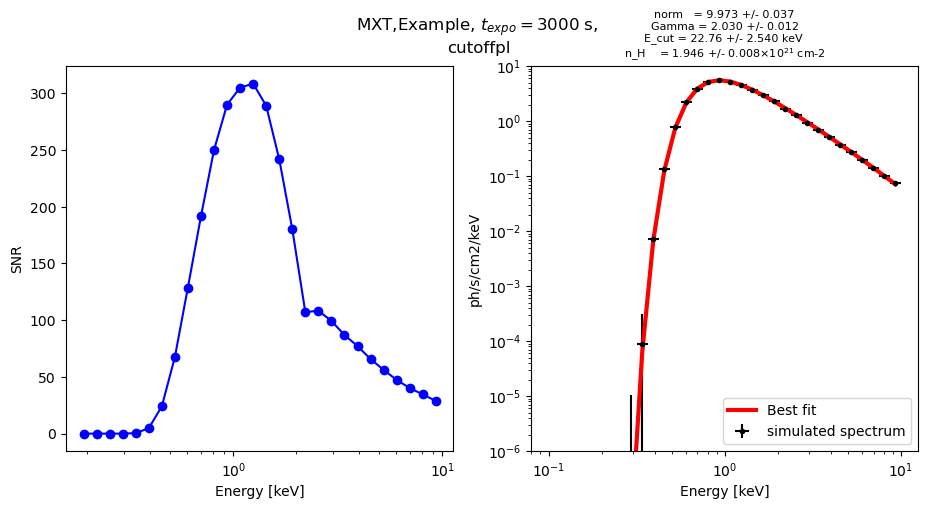

In [10]:
instrument = "MXT"
nbins = 32
tps_expo = 3000

# Optionnal parameters
title = "Example"
path_to_fig = " "
ylim1 = " "
ylim2 = [1e-6, 10]
color = "blue"

# Run make_spectra
make_spectra(instrument, nbins, tps_expo, title, path_to_fig, ylim1, ylim2, color) 